In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, holistic_model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = holistic_model.process(image)        # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def extract_keypoints(results):
    # Trích xuất keypoints của bàn tay trái (left_hand_landmarks)
    if results.left_hand_landmarks:
        lh = np.array([[res.x, res.y] for res in results.left_hand_landmarks.landmark])
    else:
        lh = np.zeros((21, 2))  # shape (21, 2) vì mỗi keypoint có 2 giá trị (x, y)
    return lh

def draw_styled_landmarks(image, results):
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [5]:
def normalize_keypoints(keypoints):
    # Kiểm tra nếu có đủ số điểm (21 điểm cho mỗi bàn tay)
    if keypoints.shape[0] != 21:
        raise ValueError(f"Số lượng điểm keypoints không hợp lệ: {keypoints.shape[0]}")

    # Cổ tay là điểm đầu tiên trong keypoints (index 0)
    wrist = keypoints[0]
    
    # Dịch các điểm sao cho cổ tay trở thành gốc tọa độ (0, 0)
    normalized_keypoints = []
    for point in keypoints:
        normalized_point = (point[0] - wrist[0], point[1] - wrist[1])  # Chỉ cần dịch x, y
        normalized_keypoints.append(normalized_point)
        
    normalized_keypoints = np.array(normalized_keypoints) 
       
    # x_min, y_min = np.min(normalized_keypoints, axis=0)
    # x_max, y_max = np.max(normalized_keypoints, axis=0)
    
    # if (x_max - x_min) == 0:
    #     print("Cảnh báo: Tọa độ x không thay đổi, bỏ qua chuẩn hóa x.")
    #     x_min, x_max = 0, 1  # Cứ để giá trị x giữ nguyên, hoặc chọn giá trị mặc định
    # if (y_max - y_min) == 0:
    #     print("Cảnh báo: Tọa độ y không thay đổi, bỏ qua chuẩn hóa y.")
    #     y_min, y_max = 0, 1  # Cứ để giá trị y giữ nguyên, hoặc chọn giá trị mặc định
    
    # min_vals = np.array([x_min, y_min])
    # max_vals = np.array([x_max, y_max])
    
    # normalized_keypoints = (normalized_keypoints - min_vals) / (max_vals - min_vals)

    return normalized_keypoints

In [84]:
def process_images(data_dir, output_dir):
    # Duyệt qua từng class trong thư mục
    classes = os.listdir(data_dir)
    for action in classes:
        class_folder = os.path.join(data_dir, action)
        if not os.path.isdir(class_folder):
            continue

        # Tạo thư mục lưu keypoints
        npy_class_dir = os.path.join(output_dir, action)
        os.makedirs(npy_class_dir, exist_ok=True)
        print(f"Đang xử lý lớp: {action}")

        # Duyệt qua từng ảnh trong class
        images = [f for f in os.listdir(class_folder) if f.endswith('.jpg')]
        images.sort()  # Đảm bảo xử lý theo thứ tự frame1, frame2, ...
        
        with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
            for img_idx, image_file in enumerate(images):
                image_path = os.path.join(class_folder, image_file)
                
                # Đọc ảnh
                frame = cv2.imread(image_path)
                if frame is None:
                    print(f"Không thể đọc ảnh: {image_path}")
                    continue

                # Trích xuất đặc trưng
                image, results = mediapipe_detection(frame, holistic)
                keypoints = extract_keypoints(results)
                
                keypoints = normalize_keypoints(keypoints)

                # Lưu đặc trưng vào file .npy
                npy_path = os.path.join(npy_class_dir, f"{img_idx}.npy")
                np.save(npy_path, keypoints)

                print(f"Lớp {action}: Lưu keypoints từ ảnh {image_file} vào {npy_path}")
                
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    cv2.destroyAllWindows()
                    return

    cv2.destroyAllWindows()

In [85]:
# Cấu trúc thư mục
data_dir = 'data'  # Thư mục chứa các lớp (class1, class2, ...)
output_dir = 'data_normalized'  # Thư mục để lưu keypoints dưới dạng .npy
process_images(data_dir, output_dir)

Đang xử lý lớp: movement
Lớp movement: Lưu keypoints từ ảnh frame_000.jpg vào data_normalized\movement\0.npy
Lớp movement: Lưu keypoints từ ảnh frame_001.jpg vào data_normalized\movement\1.npy
Lớp movement: Lưu keypoints từ ảnh frame_002.jpg vào data_normalized\movement\2.npy
Lớp movement: Lưu keypoints từ ảnh frame_003.jpg vào data_normalized\movement\3.npy
Lớp movement: Lưu keypoints từ ảnh frame_004.jpg vào data_normalized\movement\4.npy
Lớp movement: Lưu keypoints từ ảnh frame_005.jpg vào data_normalized\movement\5.npy
Lớp movement: Lưu keypoints từ ảnh frame_006.jpg vào data_normalized\movement\6.npy
Lớp movement: Lưu keypoints từ ảnh frame_007.jpg vào data_normalized\movement\7.npy
Lớp movement: Lưu keypoints từ ảnh frame_008.jpg vào data_normalized\movement\8.npy
Lớp movement: Lưu keypoints từ ảnh frame_009.jpg vào data_normalized\movement\9.npy
Lớp movement: Lưu keypoints từ ảnh frame_010.jpg vào data_normalized\movement\10.npy
Lớp movement: Lưu keypoints từ ảnh frame_011.jpg v

In [6]:
classes = ['movement', 'other']

label_map = {label:num for num, label in enumerate(classes)}
label_map

{'movement': 0, 'other': 1}

In [86]:
def create_dataset():
    data, labels = [], []

    # Duyệt qua tất cả các lớp hành động
    for action in classes:
        # Thư mục chứa các file .npy của lớp hành động
        action_folder = os.path.join('data_normalized', action)
        
        if not os.path.exists(action_folder):
            print(f"Thư mục {action_folder} không tồn tại.")
            continue

        # Lấy danh sách các file .npy trong lớp hành động, sắp xếp theo thứ tự
        npy_files = sorted([f for f in os.listdir(action_folder) if f.endswith('.npy')], key=lambda x: int(x.split('.')[0]))
        
        print(f"Đang xử lý {len(npy_files)} files cho lớp {action}.")
        
        # Duyệt qua từng file .npy và lưu dữ liệu
        for npy_file in npy_files:
            file_path = os.path.join(action_folder, npy_file)
            features = np.load(file_path)  # Đọc file .npy
            data.append(features)
            labels.append(label_map[action])  # Gắn nhãn tương ứng với hành động

    return np.array(data), np.array(labels)

sequences, labels = create_dataset()

print(f"Tổng số sequences: {len(sequences)}")
print(f"Tổng số labels: {len(labels)}")
print(f"Shape của sequences: {np.array(sequences).shape}")
print(f"Shape của labels: {np.array(labels).shape}")

# print(sequences, labels)

Đang xử lý 564 files cho lớp movement.
Đang xử lý 750 files cho lớp other.
Tổng số sequences: 1314
Tổng số labels: 1314
Shape của sequences: (1314, 21, 2)
Shape của labels: (1314,)


In [87]:
np.save("data.npy", sequences)
np.save("labels.npy", labels)

In [7]:
X = np.load("data.npy")
y = np.load("labels.npy")

print(X.shape)
print(y.shape)

(1314, 21, 2)
(1314,)


In [8]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(y_train.shape)

# print(y_train)

(1051, 21, 2)
(1051,)


In [9]:
# Xây dựng mô hình
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(21,2))) # Lớp đầu vào
model.add(Flatten())
# model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))  # Lớp ẩn
# model.add(Dropout(0.1))  # Dropout
model.add(Dense(1, activation='sigmoid'))  # Lớp đầu ra
model.summary()

d:\Phong\Coding\GestureRecognition\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1344)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        43,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,265 (169.00 KB)

 Trainable params: 43,265 (169.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# optimizer = Adam(learning_rate=0.01)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5005 - loss: 0.6752 - val_accuracy: 0.5972 - val_loss: 0.5748
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7431 - loss: 0.5318 - val_accuracy: 0.9336 - val_loss: 0.4076
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9224 - loss: 0.3690 - val_accuracy: 0.9526 - val_loss: 0.2818
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9590 - loss: 0.2468 - val_accuracy: 0.9621 - val_loss: 0.1994
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9661 - loss: 0.1812 - val_accuracy: 0.9573 - val_loss: 0.1576
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9633 - loss: 0.1445 - val_accuracy: 0.9716 - val_loss: 0.1356
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9823 - loss: 0.1082 - val_accuracy: 0.9716 - val_loss: 0.1213
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9761 - loss: 0.1080 - val_accuracy: 0.9810 - 

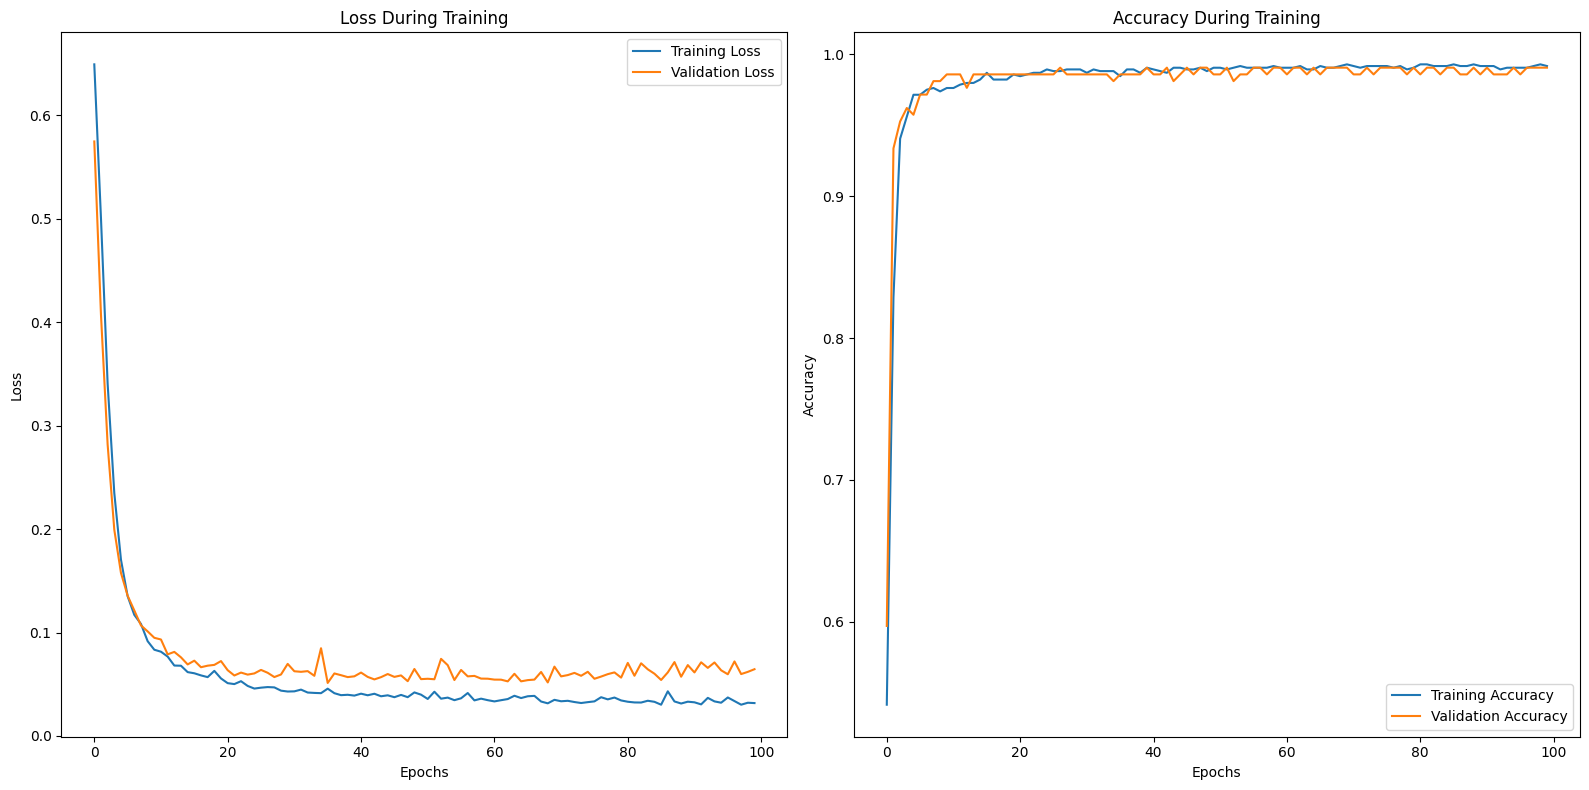

In [11]:
# Plot the loss and accuracy graphs together
plt.figure(figsize=(16, 8))

# Plot the loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# res = model.predict(X_test)
# # classes[np.argmax(res[4])]
# print(res)

In [12]:
yhat = model.predict(X_test)
ytrue = y_test

yhat = (yhat > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, yhat)
print(conf_matrix)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[[106   0]
 [  1 156]]


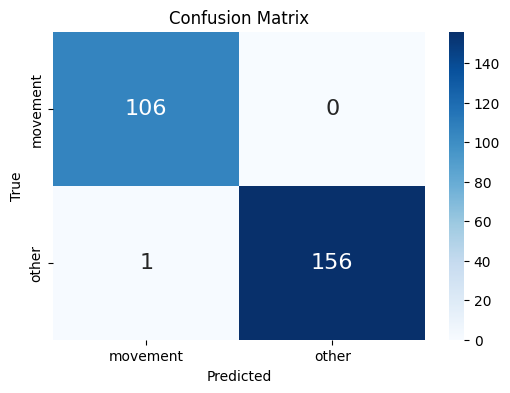

In [13]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
acc = accuracy_score(ytrue, yhat)
precision = precision_score(ytrue, yhat)
recall = recall_score(ytrue, yhat)
f1 = f1_score(ytrue, yhat)
report = classification_report(ytrue, yhat, output_dict=True)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("Báo cáo phân loại:")
print(classification_report(ytrue, yhat, target_names=classes))

Accuracy: 0.9962
Precision: 1.0000
Recall: 0.9936
F1 Score: 0.9968
Báo cáo phân loại:
              precision    recall  f1-score   support

    movement       0.99      1.00      1.00       106
       other       1.00      0.99      1.00       157

    accuracy                           1.00       263
   macro avg       1.00      1.00      1.00       263
weighted avg       1.00      1.00      1.00       263



In [15]:
cap = cv2.VideoCapture(0)

frame_counter = 0

with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        
        frame_counter += 1  # Tăng biến đếm lên mỗi khi đọc khung hình
        if frame_counter % 30 != 0:  # Chỉ xử lý mỗi khung hình thứ 3 (tùy chỉnh)
            continue

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        
        print(keypoints.shape)
        
        keypoints = normalize_keypoints(keypoints)
        
        print(f"Shape before expansion: {keypoints.shape}")
        
        # Thêm một chiều để đưa vào mô hình (cần có shape (1, 21, 2))
        keypoints = np.expand_dims(keypoints, axis=0)
        
        print(f"Shape after expansion: {keypoints.shape}")

        # Dự đoán với mô hình
        res = model.predict(keypoints)
        print(res)

        # Kiểm tra dự đoán
        if res[0] > 0.5:
            print('Other')
        else:
            print('Movement')
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
(21, 2)
Shape before expansion: (21, 2)
Shape after expansion: (1, 21, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[0.92983645]]
Other
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(21, 2)
Shape before expansion: (21, 2)
Shape after expansion: (1, 21, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.92983645]]
Other
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(21, 2)
Shape before expansion: (21, 2)
Shape after expansion: (1, 21, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.92983645]]
Other
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(21, 2)
Shape before expansion: (21, 2)
Shape after expansion: (1, 21, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.92983645]]
Other
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(21, 2)
Shape before expansion: (21, 2)
Shape after expansion: (1, 21, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[1.0955547e-05]]
Movement
<class 'mediapipe.python.solution_base.Solut

In [16]:
model.save('movement_check2.keras')